Sebastian Raschka, 2016   
`mlxtend`, a library of extension and helper modules for Python's data analysis and machine learning libraries

- GitHub repository: https://github.com/rasbt/mlxtend
- Documentation: http://rasbt.github.io/mlxtend/

View this page in [jupyter nbviewer](http://nbviewer.ipython.org/github/rasbt/mlxtend/blob/master/docs/sources/_ipynb_templates/regressor/linear_regression.ipynb)

In [2]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p matplotlib,numpy,scipy

Sebastian Raschka 
Last updated: 01/19/2016 

CPython 3.5.1
IPython 4.0.1

matplotlib 1.5.1
numpy 1.10.2
scipy 0.16.1


In [3]:
import sys
sys.path.insert(0, '../../../../')

import mlxtend
mlxtend.__version__

'0.3.0'

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Sebastian Raschka, 2015
# Sequential Feature Selection (SFS)
# mlxtend Machine Learning Library Extensions

import numpy as np
import scipy as sp
import scipy.stats
import sys
from copy import deepcopy
from itertools import combinations
from collections import deque
from sklearn.metrics import get_scorer
from sklearn.base import clone
from sklearn.base import BaseEstimator
from sklearn.base import MetaEstimatorMixin
from sklearn.base import clone
from sklearn.cross_validation import cross_val_score


class SFS(BaseEstimator, MetaEstimatorMixin):
    """ Sequential Feature Selection for Classification and Regression.

    Parameters
    ----------
    estimator : scikit-learn classifier or regressor
    k_features : int
        Number of features to select,
        where k_features < the full feature set.
    forward : bool (default: True)
        Forward selection if True, 
        backward selection otherwise
    floating : bool (default: False)
        Adds a conditional exclusion/inclusion if True.
    print_progress : bool (default: True)
        Prints progress as the number of epochs
        to stderr.
    scoring : str, (default='accuracy')
        Scoring metric in {accuracy, f1, precision, recall, roc_auc}
        for classifiers,
        {'mean_absolute_error', 'mean_squared_error',
        'median_absolute_error', 'r2'} for regressors,
        or a callable object or function with 
        signature ``scorer(estimator, X, y)``.
    cv : int (default: 5)
        Scikit-learn cross-validation generator or `int`.
        If estimator is a classifier (or y consists of integer class labels),
        stratified k-fold is performed, and regular k-fold cross-validation
        otherwise.
        No cross-validation if cv is None, False, or 0.
    skip_if_stuck: bool (default: True)
        Set to True to skip conditional 
        exlusion/inclusion if floating=True and 
        algorithm gets stuck in cycles.
    n_jobs : int (default: 1)
        The number of CPUs to use for cross validation. -1 means 'all CPUs'.
    pre_dispatch : int, or string
        Controls the number of jobs that get dispatched during parallel execution
        in cross_val_score. 
        Reducing this number can be useful to avoid an explosion of 
        memory consumption when more jobs get dispatched than CPUs can process. 
        This parameter can be:
        None, in which case all the jobs are immediately created and spawned. 
            Use this for lightweight and fast-running jobs, 
            to avoid delays due to on-demand spawning of the jobs
        An int, giving the exact number of total jobs that are spawned
        A string, giving an expression as a function 
            of n_jobs, as in ‘2*n_jobs’

    Attributes
    ----------
    k_feature_idx_ : array-like, shape = [n_predictions]
        Feature Indices of the selected feature subsets.
    k_score_ : float
        Cross validation average score of the selected subset
    subsets_ : dict
        A dictionary of selected feature subsets during the
        sequential selection, where the dictionary keys are
        the lenghts k of these feature subsets. The dictionary
        values are dictionaries themselves with the following
        keys: 'feature_idx' (tuple of indices of the feature subset)
              'cv_scores' (list individual cross-validation scores)
              'avg_score' (average cross-validation score)

    Examples
    --------
    >>> from sklearn.neighbors import KNeighborsClassifier
    >>> from sklearn.datasets import load_iris
    >>> iris = load_iris()
    >>> X = iris.data
    >>> y = iris.target
    >>> knn = KNeighborsClassifier(n_neighbors=4)
    >>> sfs = SequentialFeatureSelector(knn, k_features=2, scoring='accuracy', cv=5)
    >>> sfs = sfs.fit(X, y)
    >>> sfs.indices_
    (2, 3)
    >>> sfs.transform(X[:5])
    array([[ 1.4,  0.2],
           [ 1.4,  0.2],
           [ 1.3,  0.2],
           [ 1.5,  0.2],
           [ 1.4,  0.2]])

    >>> print('best score: %.2f' % sfs.k_score_)
    best score: 0.97
    """
    def __init__(self, estimator, k_features, 
                 forward=True, floating=False,
                 print_progress=True, scoring='accuracy', 
                 cv=5, skip_if_stuck=True, n_jobs=1,
                 pre_dispatch='2*n_jobs'):
        self.estimator = clone(estimator) 
        self.k_features = k_features
        self.forward = forward
        self.floating = floating
        self.pre_dispatch = pre_dispatch
        self.scoring = scoring
        self.scorer = get_scorer(scoring)
        self.skip_if_stuck = skip_if_stuck
        self.cv = cv
        self.print_progress = print_progress
        self.n_jobs = n_jobs

    def fit(self, X, y):
        if X.shape[1] < self.k_features:
            raise AttributeError('Features in X < k_features')
        if self.skip_if_stuck:
            sdq = deque(maxlen=4)
        else:
            sdq = deque(maxlen=0)
        
        self.subsets_ = {}
        orig_set = set(range(X.shape[1]))
        if self.forward:
            k_idx = ()
            k = 0
        else:
            k_idx = tuple(range(X.shape[1]))
            k = len(k_idx)
            k_score = self._calc_score(X, y, k_idx)
            self.subsets_[k] = {'feature_idx': k_idx, 
                                'cv_scores': k_score,
                                'avg_score': k_score.mean()}
        
        while k != self.k_features:
            prev_subset = set(k_idx)
            if self.forward:
                k_idx, k_score, cv_scores = \
                         self._inclusion(orig_set=orig_set, 
                                         subset=prev_subset)
            else:
                k_idx, k_score, cv_scores = \
                         self._exclusion(feature_set=prev_subset)

            if self.floating and not self._is_stuck(sdq):
                (new_feature,) = set(k_idx) ^ prev_subset
                if self.forward:
                    k_idx_c, k_score_c, cv_scores_c = \
                            self._exclusion(feature_set=k_idx, 
                                            fixed_feature=new_feature) 
                else:
                    k_idx_c, k_score_c, cv_scores_c = \
                            self._inclusion(orig_set=orig_set - {new_feature}, 
                                            subset=set(k_idx))
                                            
                if k_score_c and k_score_c > k_score:
                    k_idx, k_score, cv_scores = \
                                k_idx_c, k_score_c, cv_scores_c

            k = len(k_idx)
            # floating can lead to multiple same-sized subsets
            if k not in self.subsets_ or self.subsets_[k]['avg_score'] > k_score:
                self.subsets_[k] = {'feature_idx': k_idx, 
                                    'cv_scores': cv_scores,
                                    'avg_score': k_score}
            sdq.append(k_idx)

            if self.print_progress:
                sys.stderr.write('\rFeatures: %d/%d' % (
                        len(k_idx), self.k_features))
                sys.stderr.flush()

        self.k_feature_idx_ = k_idx
        self.k_score_ = k_score
        self.subsets_plus_ = dict()
        return self

    def _is_stuck(self, sdq):
        stuck = False
        if len(sdq) == 4 and (sdq[0] == sdq[2] or sdq[1] == sdq[3]):
            stuck = True
        return stuck
    
    def _calc_score(self, X, y, indices):
        if self.cv:
            scores = cross_val_score(self.estimator,
                                     X[:, indices], y,
                                     cv=self.cv,
                                     scoring=self.scorer,
                                     n_jobs=self.n_jobs,
                                     pre_dispatch=self.pre_dispatch)
        else:
            self.estimator.fit(X[:, indices], y)
            scores = np.array([self.scorer(self.estimator, X[:, indices], y)])
        return scores
    
    def _inclusion(self, orig_set, subset):
        all_avg_scores = []
        all_cv_scores = []
        all_subsets = []
        res = (None, None, None)
        remaining = orig_set - subset
        if remaining:
            for feature in remaining:
                new_subset = tuple(subset | {feature})
                cv_scores = self._calc_score(X, y, new_subset)
                all_avg_scores.append(cv_scores.mean())
                all_cv_scores.append(cv_scores)
                all_subsets.append(new_subset)
            best = np.argmax(all_avg_scores)
            res = (all_subsets[best], all_avg_scores[best], all_cv_scores[best])
        return res
    
    def _exclusion(self, feature_set, fixed_feature=None):
        n = len(feature_set)
        res = (None, None, None)
        if n > 1:
            all_avg_scores = []
            all_cv_scores = []
            all_subsets = []
            for p in combinations(feature_set, r=n-1):
                if fixed_feature and fixed_feature not in set(p):
                    continue
                cv_scores = self._calc_score(X, y, p)
                all_avg_scores.append(cv_scores.mean())
                all_cv_scores.append(cv_scores)
                all_subsets.append(p)
            best = np.argmax(all_avg_scores)
            res = (all_subsets[best], all_avg_scores[best], all_cv_scores[best])
        return res

    def transform(self, X):
        return X[:, self.k_feature_idx_]

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)
    
    def get_metric_dict(self, confidence_interval=0.95):
        fdict = deepcopy(self.subsets_)
        for k in fdict:
            std_dev = np.std(self.subsets_[k]['cv_scores'])
            bound, std_err = self._calc_confidence(self.subsets_[k]['cv_scores'], 
                                                   confidence=confidence_interval)
            fdict[k]['ci_bound'] = bound
            fdict[k]['std_dev'] = std_dev
            fdict[k]['std_err'] = std_err
        return fdict
    
    def _calc_confidence(self, ary, confidence=0.95):
        std_err = scipy.stats.sem(ary)
        bound = std_err * sp.stats.t._ppf((1 + confidence) / 2.0, len(ary))
        return bound, std_err

In [11]:
import matplotlib.pyplot as plt

def plot_sequential_feature_selection(metric_dict, 
                                      kind='std_dev',
                                      color='blue',
                                      bcolor='steelblue',
                                      marker='o',
                                      alpha=0.2,
                                      ylabel='Performance',
                                      confidence_interval=0.95):
    
    allowed = {'std_dev', 'std_err', 'ci', None}
    if kind not in allowed:
        raise AttributeError('kind not in %s' % allowed)

    fig = plt.figure()
    k_feat = sorted(metric_dict.keys())
    avg = [metric_dict[k]['avg_score'] for k in k_feat]
    
    if kind:
        upper, lower = [], []
        if kind == 'ci':
            kind = 'ci_bound'

        for k in k_feat:
            upper.append(metric_dict[k]['avg_score']
                         + metric_dict[k][kind])
            lower.append(metric_dict[k]['avg_score'] 
                         - metric_dict[k][kind])

        plt.fill_between(k_feat, 
                         upper,
                         lower,
                         alpha=alpha,
                         color=bcolor,
                         lw=1)

        if kind == 'ci_bound':
            kind = 'Confidence Interval (%d%%)' % (confidence_interval * 100)

    plt.plot(k_feat, avg, color=color, marker=marker)
    plt.ylabel(ylabel)
    plt.xlabel('Number of Features')
    feature_min = len(metric_dict[k_feat[0]]['feature_idx'])
    feature_max = len(metric_dict[k_feat[-1]]['feature_idx'])
    plt.xticks(range(feature_min, feature_max + 1), 
               range(feature_min, feature_max + 1))
    return fig

# Data

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target
knn = KNeighborsClassifier(n_neighbors=4)

# Fit

In [13]:
sfs1 = SFS(knn, k_features=3, forward=True, 
            floating=False, scoring='accuracy',
            cv=0, skip_if_stuck=True)
sfs1 = sfs1.fit(X, y)
sfs1.subsets_

Features: 3/3

{1: {'avg_score': 0.95999999999999996,
  'cv_scores': array([ 0.96]),
  'feature_idx': (3,)},
 2: {'avg_score': 0.97333333333333338,
  'cv_scores': array([ 0.97333333]),
  'feature_idx': (2, 3)},
 3: {'avg_score': 0.97333333333333338,
  'cv_scores': array([ 0.97333333]),
  'feature_idx': (1, 2, 3)}}

In [14]:
sfs1 = SFS(knn, k_features=3, forward=True, 
            floating=False, scoring='accuracy',
            cv=4, skip_if_stuck=True)
sfs1 = sfs1.fit(X, y)
sfs1.subsets_

Features: 3/3

{1: {'avg_score': 0.95299145299145294,
  'cv_scores': array([ 0.97435897,  0.94871795,  0.88888889,  1.        ]),
  'feature_idx': (3,)},
 2: {'avg_score': 0.95993589743589736,
  'cv_scores': array([ 0.97435897,  0.94871795,  0.91666667,  1.        ]),
  'feature_idx': (2, 3)},
 3: {'avg_score': 0.97275641025641035,
  'cv_scores': array([ 0.97435897,  1.        ,  0.94444444,  0.97222222]),
  'feature_idx': (1, 2, 3)}}

In [15]:
sfs2 = SFS(knn, k_features=3, forward=False, 
            floating=False, scoring='accuracy',
            cv=4, skip_if_stuck=True)
sfs2 = sfs1.fit(X, y)
sfs2.subsets_

Features: 3/3

{1: {'avg_score': 0.95299145299145294,
  'cv_scores': array([ 0.97435897,  0.94871795,  0.88888889,  1.        ]),
  'feature_idx': (3,)},
 2: {'avg_score': 0.95993589743589736,
  'cv_scores': array([ 0.97435897,  0.94871795,  0.91666667,  1.        ]),
  'feature_idx': (2, 3)},
 3: {'avg_score': 0.97275641025641035,
  'cv_scores': array([ 0.97435897,  1.        ,  0.94444444,  0.97222222]),
  'feature_idx': (1, 2, 3)}}

# Selected Features

In [16]:
print('Sequential Forward Selection (k=3):')
print(sfs1.k_feature_idx_)
print('CV Score:')
print(sfs1.k_score_)

Sequential Forward Selection (k=3):
(1, 2, 3)
CV Score:
0.972756410256


In [17]:
print('Sequential Floating Forward Selection (k=3):')
print(sfs2.k_feature_idx_)
print('CV Score:')
print(sfs2.k_score_)

Sequential Floating Forward Selection (k=3):
(1, 2, 3)
CV Score:
0.972756410256


In [24]:
print('Sequential Backward Selection (k=3):')
print(sfs3.k_feature_idx_)
print('CV Score:')
print(sfs3.k_score_)

Sequential Backward Selection (k=3):
(1, 2, 3)
CV Score:
0.972756410256


In [25]:
print('Sequential Floating Backward Selection (k=3):')
print(sfs4.k_feature_idx_)
print('CV Score:')
print(sfs4.k_score_)

Sequential Floating Backward Selection (k=3):
(1, 2, 3)
CV Score:
0.972756410256


# Feature DataFrame

In [26]:
import pandas as pd
pd.DataFrame.from_dict(sfs1.get_metric_dict(confidence_interval=0.90)).T

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
1,0.952991,0.0507249,"[0.974358974359, 0.948717948718, 0.88888888888...","(3,)",0.0412122,0.0237939
2,0.959936,0.0379925,"[0.974358974359, 0.948717948718, 0.91666666666...","(2, 3)",0.0308676,0.0178214
3,0.972756,0.0242024,"[0.974358974359, 1.0, 0.944444444444, 0.972222...","(1, 2, 3)",0.0196636,0.0113528


In [27]:
pd.DataFrame.from_dict(sfs2.get_metric_dict(confidence_interval=0.90)).T

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
1,0.952991,0.0507249,"[0.974358974359, 0.948717948718, 0.88888888888...","(3,)",0.0412122,0.0237939
2,0.959936,0.0379925,"[0.974358974359, 0.948717948718, 0.91666666666...","(2, 3)",0.0308676,0.0178214
3,0.972756,0.0242024,"[0.974358974359, 1.0, 0.944444444444, 0.972222...","(1, 2, 3)",0.0196636,0.0113528
4,0.952991,0.0286292,"[0.974358974359, 0.948717948718, 0.91666666666...","(0, 1, 2, 3)",0.0232602,0.0134293


In [28]:
pd.DataFrame.from_dict(sfs3.get_metric_dict(confidence_interval=0.90)).T

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
3,0.972756,0.0242024,"[0.974358974359, 1.0, 0.944444444444, 0.972222...","(1, 2, 3)",0.0196636,0.0113528
4,0.952991,0.0286292,"[0.974358974359, 0.948717948718, 0.91666666666...","(0, 1, 2, 3)",0.0232602,0.0134293


In [29]:
pd.DataFrame.from_dict(sfs4.get_metric_dict(confidence_interval=0.90)).T

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
3,0.972756,0.0242024,"[0.974358974359, 1.0, 0.944444444444, 0.972222...","(1, 2, 3)",0.0196636,0.0113528
4,0.952991,0.0286292,"[0.974358974359, 0.948717948718, 0.91666666666...","(0, 1, 2, 3)",0.0232602,0.0134293


# Plotting

In [30]:
%matplotlib notebook
import matplotlib.pyplot as plt

Features: 4/4

<IPython.core.display.Javascript object>


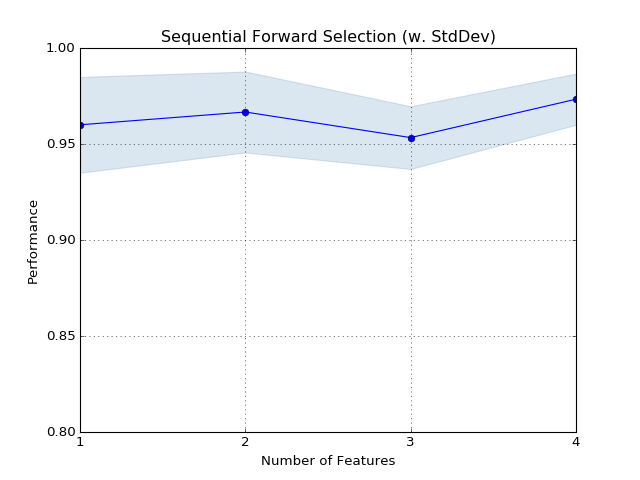

In [31]:
sfs1 = SFS(knn, k_features=4, forward=True, 
            floating=False, scoring='accuracy',
            cv=5, skip_if_stuck=True)

sfs1 = sfs1.fit(X, y)

fig1 = plot_seq_feat_select(sfs1.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


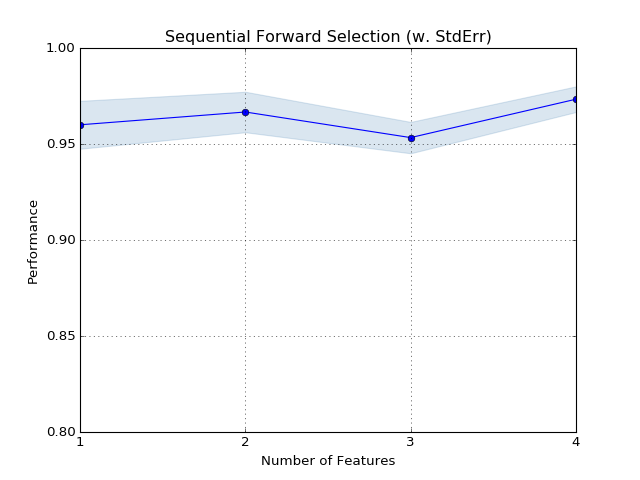

In [32]:
fig2 = plot_seq_feat_select(sfs1.get_metric_dict(), kind='std_err')
plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


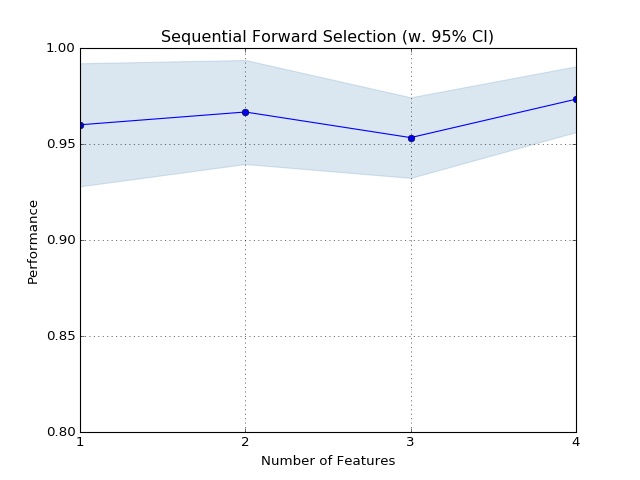

In [33]:
fig3 = plot_seq_feat_select(sfs1.get_metric_dict(), kind='ci', confidence_interval=95)
plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. 95% CI)')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


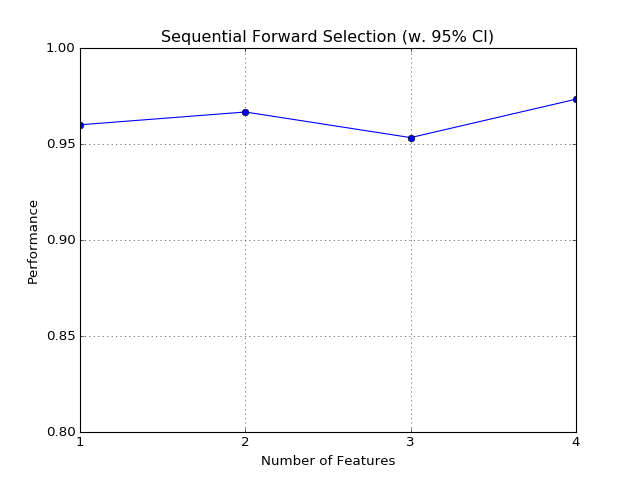

In [34]:
fig4 = plot_seq_feat_select(sfs1.get_metric_dict(), kind=None)
plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. 95% CI)')
plt.grid()
plt.show()

# Regression

In [35]:
sfs1.get_metric_dict()

{1: {'avg_score': 0.95999999999999996,
  'ci_bound': 0.032060788390921538,
  'cv_scores': array([ 0.96666667,  0.96666667,  0.93333333,  0.93333333,  1.        ]),
  'feature_idx': (3,),
  'std_dev': 0.024944382578492935,
  'std_err': 0.012472191289246468},
 2: {'avg_score': 0.96666666666666679,
  'ci_bound': 0.02709631171853797,
  'cv_scores': array([ 0.96666667,  0.96666667,  0.93333333,  0.96666667,  1.        ]),
  'feature_idx': (2, 3),
  'std_dev': 0.02108185106778919,
  'std_err': 0.010540925533894595},
 3: {'avg_score': 0.95333333333333337,
  'ci_bound': 0.020988712805908485,
  'cv_scores': array([ 0.96666667,  0.96666667,  0.93333333,  0.93333333,  0.96666667]),
  'feature_idx': (0, 2, 3),
  'std_dev': 0.016329931618554516,
  'std_err': 0.0081649658092772578},
 4: {'avg_score': 0.97333333333333338,
  'ci_bound': 0.017137212244098258,
  'cv_scores': array([ 0.96666667,  0.96666667,  0.96666667,  0.96666667,  1.        ]),
  'feature_idx': (0, 1, 2, 3),
  'std_dev': 0.0133333333

Features: 13/13

<IPython.core.display.Javascript object>


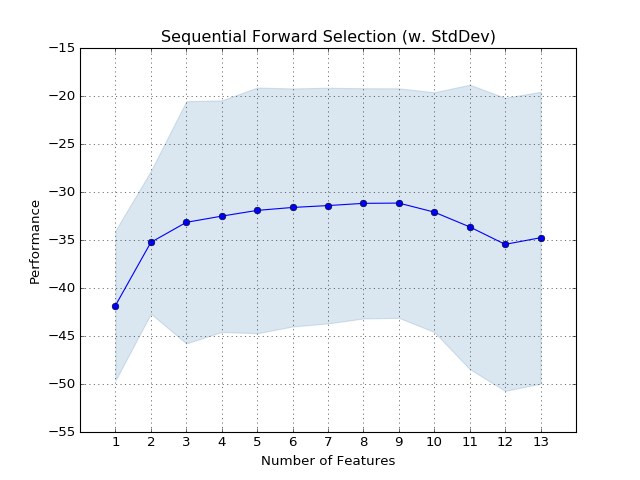

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston

boston = load_boston()
X, y = boston.data, boston.target

lr = LinearRegression()

sfs1 = SFS(lr, k_features=13, forward=True, 
            floating=False, scoring='mean_squared_error',
            cv=10, skip_if_stuck=True)

sfs1 = sfs1.fit(X, y)
fig4 = plot_seq_feat_select(sfs1.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()